## 1. Setup and Installation

In [149]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from scipy import stats
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. Define Feature Sets with Enhanced Categorization

In [150]:
# High confidence anomaly labels to filter
HIGH_CONFIDENCE_LABELS = ['medium_confidence', 'high_confidence', 'very_high_confidence']

# Integer features (must be rounded after SMOTE)
INTEGER_FEATURES = [
    'announcements', 'withdrawals', 'nlri_ann', 'dups',
    'origin_0', 'origin_2', 'origin_changes',
    'imp_wd', 'imp_wd_spath', 'imp_wd_dpath',
    'as_path_max', 'unique_as_path_max',
    'edit_distance_max',
    'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2',
    'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5',
    'edit_distance_dict_6',
    'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1',
    'number_rare_ases',
    'nadas', 'flaps'
]

# Heavy-tailed count features (benefit from log1p transform before SMOTE)
HEAVY_TAILED_FEATURES = [
    'announcements', 'withdrawals', 'nlri_ann',
    'number_rare_ases', 'nadas'
]

# Continuous features (can be float but bounded)
CONTINUOUS_FEATURES = [
    'edit_distance_avg',
    'rare_ases_avg'
]

# Bounded ratio features (need empirical min/max clipping)
BOUNDED_RATIO_FEATURES = [
    'rare_ases_avg'  # This is a ratio typically between 0 and 1
]

# Edit distance dict features (for constraint validation)
EDIT_DISTANCE_DICT_FEATURES = [
    'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2',
    'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5',
    'edit_distance_dict_6'
]

# Core features for quality validation
CORE_VALIDATION_FEATURES = [
    'announcements', 'withdrawals', 'nlri_ann', 'edit_distance_avg'
]

# All features to use for synthetic generation
ALL_FEATURES = INTEGER_FEATURES + CONTINUOUS_FEATURES

# Columns to exclude (labels, timestamps, derived scores)
EXCLUDE_COLS = [
    'label', 'confidence_label', 'window_start', 'window_end',
    'iso_forest_score', 'lof_score', 'statistical_score',
    'elliptic_score', 'cluster', 'anomaly_votes', 'consensus_score',
    'Incident'
]

# Potential grouping columns (if available in dataset)
POTENTIAL_GROUP_COLS = ['peer_asn', 'peer_ip', 'prefix', 'collector', 'Incident']

# Constant features in anomaly data (all zeros) - require special generation
CONSTANT_FEATURES = [
    'edit_distance_dict_0',      # Always 0 in original anomaly data
    'edit_distance_unique_dict_0'  # Always 0 in original anomaly data
]



print(f"Integer features: {len(INTEGER_FEATURES)}")
print(f"Heavy-tailed features: {len(HEAVY_TAILED_FEATURES)}")
print(f"Continuous features: {len(CONTINUOUS_FEATURES)}")
print(f"Total features for generation: {len(ALL_FEATURES)}")

Integer features: 25
Heavy-tailed features: 5
Continuous features: 2
Total features for generation: 27


## 3. Load and Explore Data

In [151]:
# Load data - Anomaly data with reinforced labels
DATA_PATH = '/home/smotaali/BGP_Traffic_Generation/RIPE/RIPE_INCIDENTS/all_incidents_anomalies_reinforced_v2.csv'

df = pd.read_csv(DATA_PATH)
print(f"Original dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Original dataset shape: (240116, 48)

Columns: ['announcements', 'withdrawals', 'nlri_ann', 'dups', 'origin_0', 'origin_2', 'origin_changes', 'imp_wd', 'imp_wd_spath', 'imp_wd_dpath', 'as_path_max', 'unique_as_path_max', 'edit_distance_avg', 'edit_distance_max', 'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2', 'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5', 'edit_distance_dict_6', 'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1', 'number_rare_ases', 'rare_ases_avg', 'nadas', 'flaps', 'label', 'Incident', 'window_start', 'window_end', 'method_agreement_count', 'reinforced_confidence_label', 'ensemble_score', 'classifier_confidence', 'incident_coherence', 'score_mahalanobis', 'flag_mahalanobis', 'score_ocsvm', 'flag_ocsvm', 'score_statistical', 'flag_statistical', 'score_lof', 'flag_lof', 'score_isolation_forest', 'flag_isolation_forest', 'score_elliptic_envelope', 'flag_elliptic_envelope']


,announcements,withdrawals,nlri_ann,dups,origin_0,origin_2,origin_changes,imp_wd,imp_wd_spath,imp_wd_dpath,...,score_ocsvm,flag_ocsvm,score_statistical,flag_statistical,score_lof,flag_lof,score_isolation_forest,flag_isolation_forest,score_elliptic_envelope,flag_elliptic_envelope
0,15,0,15,0,14,1,0,0,0,0,...,0.077325,1,0.002225,0,1.284992e-11,0,0.143714,0,9.738526e-08,0
1,26,1,16,0,13,13,9,1,1,0,...,0.134329,1,0.070763,1,5.534063e-11,1,0.268297,1,1.055233e-05,1
2,22,1,12,0,12,10,10,0,0,0,...,0.119135,1,0.078552,1,9.391969e-11,1,0.280614,1,6.348750e-06,1
3,16,0,16,0,14,1,0,0,0,0,...,0.076831,1,0.001182,0,1.266713e-11,0,0.127233,0,9.698348e-08,0
4,31,0,22,0,21,10,9,0,0,0,...,0.178199,1,0.070763,1,1.076816e-10,1,0.276933,1,6.196483e-06,1


In [152]:
# Check label distributions
print("Confidence label distribution:")
print(df['reinforced_confidence_label'].value_counts())

if 'label' in df.columns:
    print("\nOriginal label distribution:")
    print(df['label'].value_counts())

Confidence label distribution:
reinforced_confidence_label
needs_review            207024
low_confidence           11653
medium_confidence         7820
high_confidence           7077
very_high_confidence      6542
Name: count, dtype: int64

Original label distribution:
label
dos_attack           112958
prefix_hijacking      85599
path_manipulation     41559
Name: count, dtype: int64


In [153]:
# Filter only high confidence anomaly samples
df_high_confidence = df[df['reinforced_confidence_label'].isin(HIGH_CONFIDENCE_LABELS)].copy()
print(f"High confidence anomaly samples: {len(df_high_confidence)}")
print(f"\nDistribution within high confidence:")
print(df_high_confidence['reinforced_confidence_label'].value_counts())

High confidence anomaly samples: 21439

Distribution within high confidence:
reinforced_confidence_label
medium_confidence       7820
high_confidence         7077
very_high_confidence    6542
Name: count, dtype: int64


In [154]:
# Verify all features exist in the dataset
missing_features = [f for f in ALL_FEATURES if f not in df.columns]
if missing_features:
    print(f"WARNING: Missing features: {missing_features}")
    # Update ALL_FEATURES to only include available features
    ALL_FEATURES = [f for f in ALL_FEATURES if f in df.columns]
    INTEGER_FEATURES = [f for f in INTEGER_FEATURES if f in df.columns]
    HEAVY_TAILED_FEATURES = [f for f in HEAVY_TAILED_FEATURES if f in df.columns]
    CONTINUOUS_FEATURES = [f for f in CONTINUOUS_FEATURES if f in df.columns]
    print(f"Updated to {len(ALL_FEATURES)} available features")
else:
    print("All features found in dataset!")

All features found in dataset!


In [155]:
# Check for potential grouping columns
available_group_cols = [col for col in POTENTIAL_GROUP_COLS if col in df.columns]
print(f"Available grouping columns: {available_group_cols}")

if available_group_cols:
    for col in available_group_cols:
        n_unique = df_high_confidence[col].nunique()
        print(f"  {col}: {n_unique} unique values")

Available grouping columns: ['Incident']
  Incident: 33 unique values


In [156]:
# Prepare features - use only raw BGP features
X_anomaly = df_high_confidence[ALL_FEATURES].copy()

# Handle any missing values
X_anomaly = X_anomaly.fillna(X_anomaly.median())

print(f"Feature matrix shape: {X_anomaly.shape}")
X_anomaly.describe()

Feature matrix shape: (21439, 27)


,announcements,withdrawals,nlri_ann,dups,origin_0,origin_2,origin_changes,imp_wd,imp_wd_spath,imp_wd_dpath,...,edit_distance_dict_4,edit_distance_dict_5,edit_distance_dict_6,edit_distance_unique_dict_0,edit_distance_unique_dict_1,number_rare_ases,nadas,flaps,edit_distance_avg,rare_ases_avg
count,21439.000000,21439.000000,21439.000000,21439.000000,21439.000000,21439.000000,21439.000000,21439.000000,21439.000000,21439.000000,...,21439.000000,21439.000000,21439.000000,21439.0,21439.000000,21439.00000,21439.000000,21439.000000,21439.000000,21439.000000
mean,508.989505,39.496199,450.661691,0.487616,30.478707,1.402724,0.046224,23.344279,4.812445,18.531835,...,0.936331,0.445916,0.269136,0.0,7.811978,69.36303,2.805355,0.094874,2.286208,0.048479
std,1424.580619,190.576115,1395.846824,2.088718,287.014969,35.526391,1.121693,42.671982,12.363657,40.398590,...,5.330018,3.109194,2.542604,0.0,30.646504,155.38580,17.357650,0.914097,1.933457,0.045643
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,78.000000,1.000000,41.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,18.00000,0.000000,0.000000,1.083333,0.021543
50%,167.000000,4.000000,113.000000,0.000000,0.000000,0.000000,0.000000,15.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.0,2.000000,33.00000,0.000000,0.000000,2.000000,0.038369
75%,401.000000,17.000000,322.000000,0.000000,0.000000,0.000000,0.000000,26.000000,6.000000,21.000000,...,0.000000,0.000000,0.000000,0.0,6.000000,71.00000,1.000000,0.000000,3.000000,0.062731
max,45433.000000,13685.000000,45426.000000,88.000000,11363.000000,4016.000000,93.000000,2122.000000,480.000000,2122.000000,...,261.000000,184.000000,120.000000,0.0,2111.000000,5487.00000,732.000000,104.000000,22.000000,1.000000


In [157]:
# Store empirical bounds for all features (for clipping after inverse transform)
EMPIRICAL_BOUNDS = {}
for col in ALL_FEATURES:
    EMPIRICAL_BOUNDS[col] = {
        'min': X_anomaly[col].min(),
        'max': X_anomaly[col].max(),
        'q01': X_anomaly[col].quantile(0.01),
        'q99': X_anomaly[col].quantile(0.99)
    }

print("Empirical bounds computed for all features.")
print("\nExample bounds for key features:")
for feat in ['announcements', 'withdrawals', 'rare_ases_avg', 'edit_distance_avg']:
    if feat in EMPIRICAL_BOUNDS:
        print(f"  {feat}: [{EMPIRICAL_BOUNDS[feat]['min']:.4f}, {EMPIRICAL_BOUNDS[feat]['max']:.4f}]")

Empirical bounds computed for all features.

Example bounds for key features:
  announcements: [0.0000, 45433.0000]
  withdrawals: [0.0000, 13685.0000]
  rare_ases_avg: [0.0000, 1.0000]
  edit_distance_avg: [0.0000, 22.0000]


## 4. Enhanced Preprocessing: Log1p Transform for Heavy-Tailed Features

In [158]:
def apply_log1p_transform(df, features):
    """
    Apply log1p transform to heavy-tailed features.
    
    This helps SMOTE work better with count data that has high skewness.
    log1p(x) = log(1 + x) handles zeros gracefully.
    
    Returns:
        Transformed dataframe and dict of original stats for monitoring
    """
    result = df.copy()
    original_stats = {}
    
    for col in features:
        if col in result.columns:
            original_stats[col] = {
                'mean': result[col].mean(),
                'std': result[col].std(),
                'skew': result[col].skew(),
                'max': result[col].max()
            }
            result[col] = np.log1p(result[col])
            
    return result, original_stats


def apply_expm1_inverse(df, features):
    """
    Apply inverse log1p transform (expm1).
    expm1(x) = exp(x) - 1
    """
    result = df.copy()
    
    for col in features:
        if col in result.columns:
            result[col] = np.expm1(result[col])
            # Ensure non-negative after inverse transform
            result[col] = np.maximum(result[col], 0)
            
    return result


# Test transform on sample data
print("Testing log1p transform on heavy-tailed features:")
print("="*50)

for col in HEAVY_TAILED_FEATURES:
    if col in X_anomaly.columns:
        original_skew = X_anomaly[col].skew()
        transformed_skew = np.log1p(X_anomaly[col]).skew()
        print(f"{col}:")
        print(f"  Original skewness: {original_skew:.2f}")
        print(f"  Transformed skewness: {transformed_skew:.2f}")

Testing log1p transform on heavy-tailed features:
announcements:
  Original skewness: 11.81
  Transformed skewness: 0.44
withdrawals:
  Original skewness: 27.30
  Transformed skewness: 0.87
nlri_ann:
  Original skewness: 12.15
  Transformed skewness: 0.44
number_rare_ases:
  Original skewness: 12.76
  Transformed skewness: 0.23
nadas:
  Original skewness: 20.16
  Transformed skewness: 2.50


## 5. Enhanced Post-Processing with BGP Semantic Constraints

In [159]:
def post_process_synthetic(df, empirical_bounds=None, enforce_bgp_constraints=True):
    """
    Enhanced post-processing for synthetic data with:
    1. Integer rounding and non-negative constraints
    2. Empirical min/max clipping (not just >= 0)
    3. BGP semantic constraints enforcement
    
    Parameters:
    -----------
    df : pd.DataFrame
        Synthetic data to post-process
    empirical_bounds : dict
        Dictionary with min/max bounds for each feature
    enforce_bgp_constraints : bool
        Whether to enforce BGP domain-specific constraints
    """
    result = df.copy()
    
    # Step 1: Round integer features and ensure non-negative
    for col in INTEGER_FEATURES:
        if col in result.columns:
            result[col] = result[col].round().astype(int).clip(lower=0)
    
    # Step 2: Ensure continuous features are non-negative
    for col in CONTINUOUS_FEATURES:
        if col in result.columns:
            result[col] = result[col].clip(lower=0)
    
    # Step 3: Apply empirical bounds clipping (especially for bounded ratios)
    if empirical_bounds is not None:
        for col in BOUNDED_RATIO_FEATURES:
            if col in result.columns and col in empirical_bounds:
                bounds = empirical_bounds[col]
                result[col] = result[col].clip(
                    lower=bounds['min'],
                    upper=bounds['max']
                )
    
    # Step 4: Enforce BGP semantic constraints
    if enforce_bgp_constraints:
        result = enforce_bgp_semantic_constraints(result)
    
    # Step 5: Generate realistic distributions for constant features
    result = generate_constant_feature_distributions(result, random_state=42)
    
    return result


def enforce_bgp_semantic_constraints(df):
    """
    Enforce BGP-specific structural constraints on synthetic data.
    
    Constraints:
    1. nlri_ann <= announcements (NLRI count cannot exceed announcements)
    2. origin_0 + origin_2 <= announcements (origin types are subset of announcements)
    3. imp_wd_spath + imp_wd_dpath <= imp_wd (implicit withdrawals breakdown)
    4. edit_distance_dict sums should be consistent with edit_distance_max
    5. dups <= announcements (duplicates cannot exceed announcements)
    """
    result = df.copy()
    n_violations = {}
    
    # Constraint 1: nlri_ann <= announcements
    if 'nlri_ann' in result.columns and 'announcements' in result.columns:
        mask = result['nlri_ann'] > result['announcements']
        n_violations['nlri_ann > announcements'] = mask.sum()
        result.loc[mask, 'nlri_ann'] = result.loc[mask, 'announcements']
    
    # Constraint 2: origin_0 + origin_2 <= announcements
    if all(col in result.columns for col in ['origin_0', 'origin_2', 'announcements']):
        origin_sum = result['origin_0'] + result['origin_2']
        mask = origin_sum > result['announcements']
        n_violations['origin_0 + origin_2 > announcements'] = mask.sum()
        if mask.any():
            # Scale down proportionally
            scale_factor = result.loc[mask, 'announcements'] / origin_sum[mask]
            result.loc[mask, 'origin_0'] = (result.loc[mask, 'origin_0'] * scale_factor).round().astype(int)
            result.loc[mask, 'origin_2'] = (result.loc[mask, 'origin_2'] * scale_factor).round().astype(int)
    
    # Constraint 3: imp_wd_spath + imp_wd_dpath <= imp_wd
    if all(col in result.columns for col in ['imp_wd_spath', 'imp_wd_dpath', 'imp_wd']):
        imp_sum = result['imp_wd_spath'] + result['imp_wd_dpath']
        mask = imp_sum > result['imp_wd']
        n_violations['imp_wd_spath + imp_wd_dpath > imp_wd'] = mask.sum()
        if mask.any():
            scale_factor = result.loc[mask, 'imp_wd'] / imp_sum[mask].replace(0, 1)
            result.loc[mask, 'imp_wd_spath'] = (result.loc[mask, 'imp_wd_spath'] * scale_factor).round().astype(int)
            result.loc[mask, 'imp_wd_dpath'] = (result.loc[mask, 'imp_wd_dpath'] * scale_factor).round().astype(int)
    
    # Constraint 4: dups <= announcements
    if 'dups' in result.columns and 'announcements' in result.columns:
        mask = result['dups'] > result['announcements']
        n_violations['dups > announcements'] = mask.sum()
        result.loc[mask, 'dups'] = result.loc[mask, 'announcements']
    
    # Constraint 5: edit_distance_dict values should have max <= edit_distance_max
    if 'edit_distance_max' in result.columns:
        for ed_col in EDIT_DISTANCE_DICT_FEATURES:
            if ed_col in result.columns:
                # Individual edit distances shouldn't exceed max
                # (This is a soft constraint - edit_distance_dict_i represents count at distance i)
                pass  # This constraint is more complex and domain-specific
    
    # Report violations fixed
    total_violations = sum(n_violations.values())
    if total_violations > 0:
        print(f"\nBGP constraint violations fixed: {total_violations}")
        for constraint, count in n_violations.items():
            if count > 0:
                print(f"  {constraint}: {count}")
    
    return result


print("Post-processing functions defined!")

Post-processing functions defined!


## 5b. Generate Distributions for Constant Features

Handle features that are constant (all zeros) in the original data by generating realistic distributions based on domain knowledge.

In [160]:
def generate_constant_feature_distributions(df, original_df=None, random_state=42):
    """
    Generate realistic distributions for constant features that SMOTE couldn't handle.
    
    These features (edit_distance_dict_0, edit_distance_unique_dict_0) are always 0 
    in the original anomaly data because anomalies typically involve path changes.
    
    However, for realistic synthetic data, we generate small non-zero values based on:
    1. Domain knowledge about BGP update patterns
    2. Correlation with announcements and other edit_distance features
    
    Parameters:
    -----------
    df : pd.DataFrame
        Synthetic data with constant features set to 0
    original_df : pd.DataFrame, optional
        Original data for reference (not used if constants are true 0s)
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    pd.DataFrame
        Data with realistic constant feature distributions
    """
    np.random.seed(random_state)
    result = df.copy()
    n_samples = len(df)
    
    # ==================================================================
    # Generate edit_distance_dict_0 (count of AS path changes with distance 0)
    # ==================================================================
    # In anomaly traffic, edit_distance=0 means the AS path didn't change
    # but some other BGP attribute changed. This is relatively rare in anomalies
    # but can happen (e.g., MED changes, community updates)
    #
    # Strategy: Generate as a small fraction of total announcements
    # using a zero-inflated distribution (many 0s, some small positive values)
    
    if 'edit_distance_dict_0' in result.columns and 'announcements' in result.columns:
        announcements = result['announcements'].values
        
        # Sum of other edit_distance_dict values (path changes that occurred)
        ed_sum = np.zeros(n_samples)
        for i in range(1, 7):
            col = f'edit_distance_dict_{i}'
            if col in result.columns:
                ed_sum += result[col].values
        
        # Generate edit_distance_dict_0 based on:
        # 1. Zero-inflation: ~70% remain 0 (anomalies typically have path changes)
        # 2. For non-zero: small counts proportional to announcements
        
        # Probability of having any edit_distance=0 updates
        prob_nonzero = 0.3  # 30% chance of having some unchanged paths
        
        # Generate zero-inflated values
        is_nonzero = np.random.binomial(1, prob_nonzero, n_samples)
        
        # For non-zero samples, generate counts based on:
        # - Capped at announcements - sum(other_edit_distances)
        # - Use negative binomial for realistic count distribution
        max_possible = np.maximum(0, announcements - ed_sum).astype(int)
        
        # Negative binomial with low mean (most values small)
        raw_counts = np.random.negative_binomial(n=1, p=0.5, size=n_samples)
        
        # Apply constraints
        generated = is_nonzero * np.minimum(raw_counts, max_possible)
        
        # Ensure integer and non-negative
        result['edit_distance_dict_0'] = np.maximum(0, generated.astype(int))
        
        print(f"Generated edit_distance_dict_0:")
        print(f"  Non-zero count: {(result['edit_distance_dict_0'] > 0).sum()} / {n_samples}")
        print(f"  Mean: {result['edit_distance_dict_0'].mean():.4f}")
        print(f"  Max: {result['edit_distance_dict_0'].max()}")
    
    # ==================================================================
    # Generate edit_distance_unique_dict_0 (unique paths with distance 0)
    # ==================================================================
    # Similar logic but for unique AS paths
    # Should be <= edit_distance_dict_0 (unique paths <= total updates)
    
    if 'edit_distance_unique_dict_0' in result.columns:
        # Get edit_distance_dict_0 values we just generated
        ed0 = result['edit_distance_dict_0'].values if 'edit_distance_dict_0' in result.columns else np.zeros(n_samples)
        
        # Sum of other edit_distance_unique_dict values
        ed_unique_sum = np.zeros(n_samples)
        if 'edit_distance_unique_dict_1' in result.columns:
            ed_unique_sum += result['edit_distance_unique_dict_1'].values
        
        # Generate unique counts (must be <= total counts for distance 0)
        # Use similar zero-inflation but constrained by edit_distance_dict_0
        
        # Only generate non-zero if edit_distance_dict_0 > 0
        max_unique = ed0.copy()
        
        # For each non-zero ed0, generate unique count as fraction
        # Typically fewer unique paths than total updates
        fraction = np.random.beta(a=2, b=5, size=n_samples)  # Skewed toward lower values
        
        generated_unique = (max_unique * fraction).astype(int)
        
        # Ensure constraints
        result['edit_distance_unique_dict_0'] = np.maximum(0, generated_unique.astype(int))
        
        print(f"Generated edit_distance_unique_dict_0:")
        print(f"  Non-zero count: {(result['edit_distance_unique_dict_0'] > 0).sum()} / {n_samples}")
        print(f"  Mean: {result['edit_distance_unique_dict_0'].mean():.4f}")
        print(f"  Max: {result['edit_distance_unique_dict_0'].max()}")
    
    return result


print("Constant feature distribution generation function defined!")


Constant feature distribution generation function defined!


## 6. k_neighbors Validation and Safe SMOTE Configuration

In [161]:
def validate_k_neighbors(n_samples, requested_k, method_name="SMOTE"):
    """
    Validate and adjust k_neighbors to avoid silent failures.
    
    SMOTE requires k_neighbors < number of minority samples.
    This function ensures safe k_neighbors selection and warns if adjusted.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples in the minority class
    requested_k : int
        Requested number of neighbors
    method_name : str
        Name of the method for logging
        
    Returns:
    --------
    int : Safe k_neighbors value
    """
    max_k = n_samples - 1
    
    if requested_k >= n_samples:
        safe_k = max(1, max_k)
        print(f"WARNING [{method_name}]: k_neighbors ({requested_k}) >= n_samples ({n_samples})")
        print(f"  Adjusting k_neighbors to {safe_k}")
        return safe_k
    
    return requested_k


def get_safe_smote_config(n_minority_samples, base_k=5):
    """
    Get safe SMOTE configuration based on available samples.
    
    Returns a dictionary with recommended parameters.
    """
    config = {
        'k_neighbors': validate_k_neighbors(n_minority_samples, base_k),
        'n_minority_samples': n_minority_samples,
        'is_safe': n_minority_samples >= 2  # Minimum for SMOTE
    }
    
    if not config['is_safe']:
        print(f"WARNING: Not enough minority samples ({n_minority_samples}) for SMOTE. Minimum is 2.")
    
    return config


# Test validation
print("Testing k_neighbors validation:")
print("="*50)
test_cases = [(100, 5), (10, 5), (5, 5), (3, 5), (2, 5)]
for n_samples, requested_k in test_cases:
    safe_k = validate_k_neighbors(n_samples, requested_k, "Test")
    print(f"  n_samples={n_samples}, requested_k={requested_k} -> safe_k={safe_k}")

Testing k_neighbors validation:
  n_samples=100, requested_k=5 -> safe_k=5
  n_samples=10, requested_k=5 -> safe_k=5
WARNING [Test]: k_neighbors (5) >= n_samples (5)
  Adjusting k_neighbors to 4
  n_samples=5, requested_k=5 -> safe_k=4
WARNING [Test]: k_neighbors (5) >= n_samples (3)
  Adjusting k_neighbors to 2
  n_samples=3, requested_k=5 -> safe_k=2
WARNING [Test]: k_neighbors (5) >= n_samples (2)
  Adjusting k_neighbors to 1
  n_samples=2, requested_k=5 -> safe_k=1


## 7. Enhanced SMOTE Generation Functions

In [162]:
def generate_with_smote_enhanced(
    X, 
    n_samples, 
    use_log_transform=True,
    enforce_constraints=True,
    random_state=42
):
    """
    Enhanced SMOTE generation with:
    - Log1p transform for heavy-tailed features
    - k_neighbors validation
    - Empirical bounds clipping
    - BGP constraint enforcement
    """
    n_original = len(X)
    
    # Step 1: Apply log1p transform if requested
    if use_log_transform:
        X_work, _ = apply_log1p_transform(X.copy(), HEAVY_TAILED_FEATURES)
    else:
        X_work = X.copy()
    
    # Step 2: Create artificial labels with validated minority size
    minority_size = max(10, int(n_original * 0.01))
    
    # Validate k_neighbors
    safe_k = validate_k_neighbors(minority_size, 5, "Standard SMOTE")
    
    np.random.seed(random_state)
    minority_idx = np.random.choice(n_original, minority_size, replace=False)
    
    X_array = X_work.values
    y = np.zeros(n_original)
    y[minority_idx] = 1
    
    desired_minority = n_samples + minority_size
    
    # Step 3: Apply SMOTE with safe k_neighbors
    smote = SMOTE(
        sampling_strategy={1: desired_minority},
        k_neighbors=safe_k,
        random_state=random_state
    )
    
    X_resampled, y_resampled = smote.fit_resample(X_array, y)
    synthetic_samples = X_resampled[y_resampled == 1][minority_size:]
    
    result = pd.DataFrame(synthetic_samples, columns=X.columns)
    
    # Step 4: Apply inverse log transform if used
    if use_log_transform:
        result = apply_expm1_inverse(result, HEAVY_TAILED_FEATURES)
    
    # Step 5: Post-process with empirical bounds and BGP constraints
    result = post_process_synthetic(
        result, 
        empirical_bounds=EMPIRICAL_BOUNDS,
        enforce_bgp_constraints=enforce_constraints
    )
    
    return result

In [163]:
def generate_with_borderline_smote_enhanced(
    X, 
    n_samples, 
    use_log_transform=True,
    enforce_constraints=True,
    kind='borderline-1',  # 'borderline-1' or 'borderline-2'
    random_state=42
):
    """
    Enhanced Borderline SMOTE generation.
    
    BorderlineSMOTE focuses on samples near the decision boundary,
    which may be useful for model training (not necessarily for traffic simulation).
    
    Parameters:
    -----------
    kind : str
        'borderline-1': Only oversample borderline samples
        'borderline-2': Also consider samples from majority class
    """
    n_original = len(X)
    
    if use_log_transform:
        X_work, _ = apply_log1p_transform(X.copy(), HEAVY_TAILED_FEATURES)
    else:
        X_work = X.copy()
    
    minority_size = max(10, int(n_original * 0.01))
    safe_k = validate_k_neighbors(minority_size, 5, "Borderline SMOTE")
    
    np.random.seed(random_state)
    minority_idx = np.random.choice(n_original, minority_size, replace=False)
    
    X_array = X_work.values
    y = np.zeros(n_original)
    y[minority_idx] = 1
    
    desired_minority = n_samples + minority_size
    
    borderline_smote = BorderlineSMOTE(
        sampling_strategy={1: desired_minority},
        k_neighbors=safe_k,
        m_neighbors=min(10, n_original - 1),
        kind=kind,
        random_state=random_state
    )
    
    X_resampled, y_resampled = borderline_smote.fit_resample(X_array, y)
    synthetic_samples = X_resampled[y_resampled == 1][minority_size:]
    
    result = pd.DataFrame(synthetic_samples, columns=X.columns)
    
    if use_log_transform:
        result = apply_expm1_inverse(result, HEAVY_TAILED_FEATURES)
    
    result = post_process_synthetic(
        result,
        empirical_bounds=EMPIRICAL_BOUNDS,
        enforce_bgp_constraints=enforce_constraints
    )
    
    return result

In [164]:
def generate_with_adasyn_enhanced(
    X, 
    n_samples, 
    use_log_transform=True,
    enforce_constraints=True,
    random_state=42
):
    """
    Enhanced ADASYN generation.
    Adaptively generates more samples in regions where density is low.
    """
    n_original = len(X)
    
    if use_log_transform:
        X_work, _ = apply_log1p_transform(X.copy(), HEAVY_TAILED_FEATURES)
    else:
        X_work = X.copy()
    
    minority_size = max(10, int(n_original * 0.01))
    safe_k = validate_k_neighbors(minority_size, 5, "ADASYN")
    
    np.random.seed(random_state)
    minority_idx = np.random.choice(n_original, minority_size, replace=False)
    
    X_array = X_work.values
    y = np.zeros(n_original)
    y[minority_idx] = 1
    
    desired_minority = n_samples + minority_size
    
    adasyn = ADASYN(
        sampling_strategy={1: desired_minority},
        n_neighbors=safe_k,
        random_state=random_state
    )
    
    try:
        X_resampled, y_resampled = adasyn.fit_resample(X_array, y)
        synthetic_samples = X_resampled[y_resampled == 1][minority_size:]
        result = pd.DataFrame(synthetic_samples, columns=X.columns)
        
        if use_log_transform:
            result = apply_expm1_inverse(result, HEAVY_TAILED_FEATURES)
        
        result = post_process_synthetic(
            result,
            empirical_bounds=EMPIRICAL_BOUNDS,
            enforce_bgp_constraints=enforce_constraints
        )
        return result
    
    except ValueError as e:
        print(f"ADASYN failed: {e}. Falling back to standard SMOTE.")
        return generate_with_smote_enhanced(
            X, n_samples, use_log_transform, enforce_constraints, random_state
        )

In [165]:
def generate_with_kmeans_smote_enhanced(
    X, 
    n_samples, 
    n_clusters=10, 
    use_log_transform=True,
    enforce_constraints=True,
    random_state=42
):
    """
    Enhanced K-Means clustering + SMOTE.
    Clusters the data first, then applies SMOTE within each cluster.
    """
    np.random.seed(random_state)
    
    if use_log_transform:
        X_work, _ = apply_log1p_transform(X.copy(), HEAVY_TAILED_FEATURES)
    else:
        X_work = X.copy()
    
    X_array = X_work.values
    
    # Scale for clustering
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_array)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    cluster_sizes = np.bincount(cluster_labels)
    samples_per_cluster = (cluster_sizes / cluster_sizes.sum() * n_samples).astype(int)
    samples_per_cluster = np.maximum(samples_per_cluster, 1)
    
    synthetic_all = []
    
    for cluster_id in range(n_clusters):
        cluster_mask = cluster_labels == cluster_id
        X_cluster = X_array[cluster_mask]
        
        if len(X_cluster) < 3:
            continue
            
        n_to_generate = samples_per_cluster[cluster_id]
        minority_size = max(2, int(len(X_cluster) * 0.1))
        
        # Validate k_neighbors for this cluster
        safe_k = validate_k_neighbors(
            minority_size, 3, f"K-Means Cluster {cluster_id}"
        )
        
        if safe_k < 1:
            continue
            
        minority_idx = np.random.choice(len(X_cluster), minority_size, replace=False)
        
        y_cluster = np.zeros(len(X_cluster))
        y_cluster[minority_idx] = 1
        
        try:
            smote = SMOTE(
                sampling_strategy={1: n_to_generate + minority_size},
                k_neighbors=safe_k,
                random_state=random_state
            )
            X_res, y_res = smote.fit_resample(X_cluster, y_cluster)
            synthetic = X_res[y_res == 1][minority_size:]
            synthetic_all.append(synthetic)
        except Exception as e:
            print(f"  Cluster {cluster_id} failed: {e}")
            continue
    
    if synthetic_all:
        synthetic_combined = np.vstack(synthetic_all)
        result = pd.DataFrame(synthetic_combined[:n_samples], columns=X.columns)
        
        if use_log_transform:
            result = apply_expm1_inverse(result, HEAVY_TAILED_FEATURES)
        
        result = post_process_synthetic(
            result,
            empirical_bounds=EMPIRICAL_BOUNDS,
            enforce_bgp_constraints=enforce_constraints
        )
        return result
    else:
        print("K-Means SMOTE failed for all clusters. Falling back to standard SMOTE.")
        return generate_with_smote_enhanced(
            X, n_samples, use_log_transform, enforce_constraints, random_state
        )

## 8. Stratified SMOTE (Group-based Generation)

In [166]:
def generate_stratified_smote(
    df_full,
    feature_cols,
    group_col,
    n_samples,
    min_group_size=20,
    use_log_transform=True,
    enforce_constraints=True,
    random_state=42
):
    """
    Stratified SMOTE: Apply SMOTE within subpopulations (e.g., by peer or prefix).
    
    This avoids mixing very different behaviors from different groups.
    
    Parameters:
    -----------
    df_full : pd.DataFrame
        Full dataframe with features and grouping column
    feature_cols : list
        List of feature column names
    group_col : str
        Column to group by (e.g., 'peer_asn', 'prefix', 'Incident')
    n_samples : int
        Total number of samples to generate
    min_group_size : int
        Minimum group size to apply SMOTE (smaller groups are skipped)
    """
    np.random.seed(random_state)
    
    # Get group sizes
    group_sizes = df_full.groupby(group_col).size()
    valid_groups = group_sizes[group_sizes >= min_group_size].index.tolist()
    
    print(f"Stratified SMOTE by '{group_col}':")
    print(f"  Total groups: {len(group_sizes)}")
    print(f"  Valid groups (>= {min_group_size} samples): {len(valid_groups)}")
    
    if len(valid_groups) == 0:
        print(f"  No valid groups found. Falling back to non-stratified SMOTE.")
        return generate_with_smote_enhanced(
            df_full[feature_cols], n_samples, use_log_transform, 
            enforce_constraints, random_state
        )
    
    # Calculate samples per group proportionally
    valid_sizes = group_sizes[valid_groups]
    samples_per_group = (valid_sizes / valid_sizes.sum() * n_samples).astype(int)
    samples_per_group = np.maximum(samples_per_group, 1)
    
    synthetic_all = []
    
    for group_id in valid_groups:
        group_df = df_full[df_full[group_col] == group_id]
        X_group = group_df[feature_cols].copy()
        n_to_generate = samples_per_group[group_id]
        
        if len(X_group) < 10:
            continue
        
        try:
            synthetic_group = generate_with_smote_enhanced(
                X_group, 
                n_to_generate,
                use_log_transform=use_log_transform,
                enforce_constraints=enforce_constraints,
                random_state=random_state + hash(str(group_id)) % 1000
            )
            synthetic_group[group_col] = group_id
            synthetic_all.append(synthetic_group)
        except Exception as e:
            print(f"  Group '{group_id}' failed: {e}")
            continue
    
    if synthetic_all:
        result = pd.concat(synthetic_all, ignore_index=True)
        print(f"  Generated {len(result)} samples across {len(synthetic_all)} groups")
        return result
    else:
        print("  All groups failed. Falling back to non-stratified SMOTE.")
        return generate_with_smote_enhanced(
            df_full[feature_cols], n_samples, use_log_transform,
            enforce_constraints, random_state
        )


print("Stratified SMOTE function defined!")

Stratified SMOTE function defined!


## 9. Distributional Validation Tests

In [167]:
def kolmogorov_smirnov_tests(original, synthetic, features=None, alpha=0.05):
    """
    Perform Kolmogorov-Smirnov tests to compare distributions.
    
    The KS test measures the maximum difference between the empirical
    cumulative distribution functions of two samples.
    
    Parameters:
    -----------
    original : pd.DataFrame
        Original data
    synthetic : pd.DataFrame
        Synthetic data
    features : list
        Features to test (default: core validation features)
    alpha : float
        Significance level
        
    Returns:
    --------
    pd.DataFrame : Results with KS statistic and p-value for each feature
    """
    if features is None:
        features = CORE_VALIDATION_FEATURES
    
    results = []
    
    for col in features:
        if col in original.columns and col in synthetic.columns:
            ks_stat, p_value = ks_2samp(original[col], synthetic[col])
            
            results.append({
                'Feature': col,
                'KS Statistic': ks_stat,
                'P-Value': p_value,
                'Significant Diff': 'Yes' if p_value < alpha else 'No',
                'Quality': 'Good' if ks_stat < 0.1 else ('Fair' if ks_stat < 0.2 else 'Poor')
            })
    
    return pd.DataFrame(results)


def compare_correlation_matrices(original, synthetic, features=None):
    """
    Compare correlation matrices between original and synthetic data.
    
    This checks if SMOTE preserves the dependency structure, not just marginals.
    
    Returns:
    --------
    dict with correlation matrices and difference metrics
    """
    if features is None:
        features = CORE_VALIDATION_FEATURES + ['origin_0', 'origin_2', 'dups']
    
    # Ensure features exist in both
    common_features = [f for f in features if f in original.columns and f in synthetic.columns]
    
    corr_original = original[common_features].corr()
    corr_synthetic = synthetic[common_features].corr()
    
    # Calculate difference metrics
    corr_diff = np.abs(corr_original - corr_synthetic)
    
    # Frobenius norm of difference (overall measure)
    frobenius_norm = np.sqrt((corr_diff ** 2).sum().sum())
    
    # Max absolute difference
    max_diff = corr_diff.values.max()
    
    # Mean absolute difference
    mean_diff = corr_diff.values.mean()
    
    return {
        'corr_original': corr_original,
        'corr_synthetic': corr_synthetic,
        'corr_diff': corr_diff,
        'frobenius_norm': frobenius_norm,
        'max_diff': max_diff,
        'mean_diff': mean_diff,
        'features': common_features
    }


def plot_correlation_comparison(corr_results, figsize=(16, 5)):
    """
    Plot correlation matrix comparison.
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Original correlation
    sns.heatmap(
        corr_results['corr_original'], 
        annot=True, fmt='.2f', cmap='coolwarm',
        center=0, vmin=-1, vmax=1,
        ax=axes[0]
    )
    axes[0].set_title('Original Anomaly Data Correlation')
    
    # Synthetic correlation
    sns.heatmap(
        corr_results['corr_synthetic'], 
        annot=True, fmt='.2f', cmap='coolwarm',
        center=0, vmin=-1, vmax=1,
        ax=axes[1]
    )
    axes[1].set_title('Synthetic Anomaly Data Correlation')
    
    # Difference
    sns.heatmap(
        corr_results['corr_diff'], 
        annot=True, fmt='.2f', cmap='Reds',
        vmin=0, vmax=0.5,
        ax=axes[2]
    )
    axes[2].set_title(f"Absolute Difference (Mean: {corr_results['mean_diff']:.3f})")
    
    plt.tight_layout()
    return fig


def plot_distribution_comparison(original, synthetic, features=None, figsize=(15, 10)):
    """
    Plot distribution comparisons for key features.
    """
    if features is None:
        features = CORE_VALIDATION_FEATURES
    
    n_features = len(features)
    n_cols = 2
    n_rows = (n_features + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    for i, col in enumerate(features):
        ax = axes[i]
        
        # Plot histograms
        ax.hist(original[col], bins=50, alpha=0.5, label='Original', density=True)
        ax.hist(synthetic[col], bins=50, alpha=0.5, label='Synthetic', density=True)
        
        # Add KS statistic
        ks_stat, p_value = ks_2samp(original[col], synthetic[col])
        ax.set_title(f'{col}\nKS={ks_stat:.3f}, p={p_value:.3e}')
        ax.legend()
    
    # Hide unused axes
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    return fig


print("Distributional validation functions defined!")

Distributional validation functions defined!


## 10. Enhanced Statistics Comparison

In [168]:
def compare_statistics_enhanced(original, synthetic, name):
    """
    Enhanced comparison with more metrics and all features.
    """
    print(f"\n{'='*70}")
    print(f"Enhanced Comparison: {name}")
    print(f"{'='*70}")
    
    results = []
    for col in ALL_FEATURES:
        if col not in original.columns or col not in synthetic.columns:
            continue
            
        orig_mean = original[col].mean()
        orig_std = original[col].std()
        orig_median = original[col].median()
        orig_skew = original[col].skew()
        
        synth_mean = synthetic[col].mean()
        synth_std = synthetic[col].std()
        synth_median = synthetic[col].median()
        synth_skew = synthetic[col].skew()
        
        mean_diff = abs(orig_mean - synth_mean) / (abs(orig_mean) + 1e-10) * 100
        std_diff = abs(orig_std - synth_std) / (abs(orig_std) + 1e-10) * 100
        median_diff = abs(orig_median - synth_median) / (abs(orig_median) + 1e-10) * 100
        
        # KS test
        ks_stat, ks_pval = ks_2samp(original[col], synthetic[col])
        
        results.append({
            'Feature': col,
            'Orig Mean': f'{orig_mean:.2f}',
            'Synth Mean': f'{synth_mean:.2f}',
            'Mean Diff %': f'{mean_diff:.1f}%',
            'Orig Std': f'{orig_std:.2f}',
            'Synth Std': f'{synth_std:.2f}',
            'Std Diff %': f'{std_diff:.1f}%',
            'KS Stat': f'{ks_stat:.3f}',
            'Quality': 'Good' if ks_stat < 0.1 else ('Fair' if ks_stat < 0.2 else 'Poor')
        })
    
    return pd.DataFrame(results)


print("Enhanced statistics comparison function defined!")

Enhanced statistics comparison function defined!


## 11. Generate Synthetic Anomaly Data

In [169]:
# Configuration
N_SYNTHETIC = 20000  # Number of synthetic samples to generate
USE_LOG_TRANSFORM = True  # Apply log1p transform for heavy-tailed features
ENFORCE_BGP_CONSTRAINTS = True  # Enforce BGP semantic constraints

print(f"Configuration:")
print(f"  N_SYNTHETIC: {N_SYNTHETIC}")
print(f"  USE_LOG_TRANSFORM: {USE_LOG_TRANSFORM}")
print(f"  ENFORCE_BGP_CONSTRAINTS: {ENFORCE_BGP_CONSTRAINTS}")
print(f"\nOriginal high confidence anomaly samples: {len(X_anomaly)}")
print(f"\nGenerating synthetic anomaly samples...")

Configuration:
  N_SYNTHETIC: 20000
  USE_LOG_TRANSFORM: True
  ENFORCE_BGP_CONSTRAINTS: True

Original high confidence anomaly samples: 21439

Generating synthetic anomaly samples...


In [170]:
# Method 1: Enhanced Standard SMOTE
print("\n" + "="*60)
print("Generating with Enhanced Standard SMOTE...")
print("="*60)

synthetic_smote = generate_with_smote_enhanced(
    X_anomaly, 
    N_SYNTHETIC,
    use_log_transform=USE_LOG_TRANSFORM,
    enforce_constraints=ENFORCE_BGP_CONSTRAINTS
)
print(f"Generated: {len(synthetic_smote)} samples")
synthetic_smote.head()


Generating with Enhanced Standard SMOTE...

BGP constraint violations fixed: 2481
  origin_0 + origin_2 > announcements: 924
  imp_wd_spath + imp_wd_dpath > imp_wd: 1557
Generated edit_distance_dict_0:
  Non-zero count: 3010 / 20000
  Mean: 0.3049
  Max: 14
Generated edit_distance_unique_dict_0:
  Non-zero count: 431 / 20000
  Mean: 0.0274
  Max: 5
Generated: 20000 samples


,announcements,withdrawals,nlri_ann,dups,origin_0,origin_2,origin_changes,imp_wd,imp_wd_spath,imp_wd_dpath,...,edit_distance_dict_4,edit_distance_dict_5,edit_distance_dict_6,edit_distance_unique_dict_0,edit_distance_unique_dict_1,number_rare_ases,nadas,flaps,edit_distance_avg,rare_ases_avg
0,145,2,40,1,0,0,0,60,1,59,...,0,0,0,0,21,25,1,0,1.972612,0.031695
1,651,56,640,0,602,49,2,1,0,1,...,1,0,0,0,1,137,0,0,1.278389,0.037080
2,1577,3,1493,0,0,0,0,9,1,8,...,0,0,0,0,5,201,1,0,1.055923,0.028392
3,56,6,24,0,0,0,0,21,11,9,...,0,0,0,0,2,21,0,0,4.186349,0.066592
4,778,22,562,0,0,0,0,2,0,2,...,0,0,0,0,1,113,1,0,2.122021,0.032635


In [171]:
# Method 2: Enhanced Borderline SMOTE
print("\n" + "="*60)
print("Generating with Enhanced Borderline SMOTE...")
print("="*60)

synthetic_borderline = generate_with_borderline_smote_enhanced(
    X_anomaly, 
    N_SYNTHETIC,
    use_log_transform=USE_LOG_TRANSFORM,
    enforce_constraints=ENFORCE_BGP_CONSTRAINTS,
    kind='borderline-1'
)
print(f"Generated: {len(synthetic_borderline)} samples")
synthetic_borderline.head()


Generating with Enhanced Borderline SMOTE...

BGP constraint violations fixed: 4917
  origin_0 + origin_2 > announcements: 3441
  imp_wd_spath + imp_wd_dpath > imp_wd: 1476
Generated edit_distance_dict_0:
  Non-zero count: 3010 / 20000
  Mean: 0.3051
  Max: 14
Generated edit_distance_unique_dict_0:
  Non-zero count: 431 / 20000
  Mean: 0.0275
  Max: 5
Generated: 20000 samples


,announcements,withdrawals,nlri_ann,dups,origin_0,origin_2,origin_changes,imp_wd,imp_wd_spath,imp_wd_dpath,...,edit_distance_dict_4,edit_distance_dict_5,edit_distance_dict_6,edit_distance_unique_dict_0,edit_distance_unique_dict_1,number_rare_ases,nadas,flaps,edit_distance_avg,rare_ases_avg
0,75,3,30,2,0,0,0,24,2,22,...,0,0,0,0,20,20,1,0,1.005898,0.049147
1,129,7,101,0,0,0,0,10,6,4,...,0,0,2,0,1,48,1,0,4.259253,0.079520
2,173,6,128,1,0,0,0,17,14,3,...,0,0,0,0,2,19,1,0,0.824521,0.032895
3,75,4,29,0,0,0,0,24,0,24,...,0,0,0,0,17,6,0,0,1.236276,0.012190
4,120,1,37,0,0,0,0,57,7,50,...,1,0,2,0,6,17,0,0,2.079510,0.029627


In [172]:
# Method 3: Enhanced ADASYN
print("\n" + "="*60)
print("Generating with Enhanced ADASYN...")
print("="*60)

synthetic_adasyn = generate_with_adasyn_enhanced(
    X_anomaly, 
    N_SYNTHETIC,
    use_log_transform=USE_LOG_TRANSFORM,
    enforce_constraints=ENFORCE_BGP_CONSTRAINTS
)
print(f"Generated: {len(synthetic_adasyn)} samples")
synthetic_adasyn.head()


Generating with Enhanced ADASYN...

BGP constraint violations fixed: 2397
  origin_0 + origin_2 > announcements: 951
  imp_wd_spath + imp_wd_dpath > imp_wd: 1446
Generated edit_distance_dict_0:
  Non-zero count: 2948 / 19983
  Mean: 0.2944
  Max: 11
Generated edit_distance_unique_dict_0:
  Non-zero count: 426 / 19983
  Mean: 0.0272
  Max: 5
Generated: 19983 samples


,announcements,withdrawals,nlri_ann,dups,origin_0,origin_2,origin_changes,imp_wd,imp_wd_spath,imp_wd_dpath,...,edit_distance_dict_4,edit_distance_dict_5,edit_distance_dict_6,edit_distance_unique_dict_0,edit_distance_unique_dict_1,number_rare_ases,nadas,flaps,edit_distance_avg,rare_ases_avg
0,89,1,86,0,0,0,0,2,0,2,...,0,0,1,0,0,25,0,0,7.171686,0.050063
1,186,3,180,0,0,0,0,2,0,2,...,0,0,2,0,0,49,0,0,5.671206,0.058941
2,52,5,47,0,0,0,0,4,2,2,...,0,0,1,1,0,59,2,0,4.656832,0.243360
3,185,2,180,0,0,0,0,2,0,2,...,0,0,2,0,0,47,0,0,5.893591,0.057064
4,199,21,177,0,0,0,0,4,0,4,...,0,2,0,0,2,75,4,0,3.410438,0.078024


In [173]:
# Method 4: K-Means SMOTE
print("\n" + "="*60)
print("Generating with K-Means SMOTE...")
print("="*60)

synthetic_kmeans = generate_with_kmeans_smote_enhanced(
    X_anomaly, 
    N_SYNTHETIC,
    n_clusters=10,
    use_log_transform=USE_LOG_TRANSFORM,
    enforce_constraints=ENFORCE_BGP_CONSTRAINTS
)
print(f"Generated: {len(synthetic_kmeans)} samples")
synthetic_kmeans.head()


Generating with K-Means SMOTE...
WARNING [K-Means Cluster 3]: k_neighbors (3) >= n_samples (2)
  Adjusting k_neighbors to 1
WARNING [K-Means Cluster 5]: k_neighbors (3) >= n_samples (2)
  Adjusting k_neighbors to 1

BGP constraint violations fixed: 1444
  origin_0 + origin_2 > announcements: 374
  imp_wd_spath + imp_wd_dpath > imp_wd: 1070
Generated edit_distance_dict_0:
  Non-zero count: 2963 / 19993
  Mean: 0.2953
  Max: 13
Generated edit_distance_unique_dict_0:
  Non-zero count: 444 / 19993
  Mean: 0.0277
  Max: 5
Generated: 19993 samples


,announcements,withdrawals,nlri_ann,dups,origin_0,origin_2,origin_changes,imp_wd,imp_wd_spath,imp_wd_dpath,...,edit_distance_dict_4,edit_distance_dict_5,edit_distance_dict_6,edit_distance_unique_dict_0,edit_distance_unique_dict_1,number_rare_ases,nadas,flaps,edit_distance_avg,rare_ases_avg
0,6217,8,5722,0,0,0,0,0,0,0,...,0,0,0,0,0,672,0,0,0.000000,0.022287
1,308,17,274,0,306,2,0,1,0,1,...,0,0,0,0,1,81,0,0,1.267586,0.056311
2,2065,0,2036,0,0,0,0,0,0,0,...,0,0,0,0,0,234,0,0,0.000000,0.020682
3,3354,1,3354,0,0,0,0,0,0,0,...,0,0,0,0,0,252,0,0,0.000000,0.017074
4,195,6,162,0,0,0,0,2,0,2,...,0,0,0,0,2,56,1,0,1.000000,0.049604


In [174]:
# Method 5: Stratified SMOTE (if grouping column available)
# Try using 'Incident' as grouping column if available
synthetic_stratified = None

if 'Incident' in df_high_confidence.columns:
    print("\n" + "="*60)
    print("Generating with Stratified SMOTE (by Incident)...")
    print("="*60)
    
    synthetic_stratified = generate_stratified_smote(
        df_high_confidence,
        ALL_FEATURES,
        'Incident',
        N_SYNTHETIC,
        min_group_size=20,
        use_log_transform=USE_LOG_TRANSFORM,
        enforce_constraints=ENFORCE_BGP_CONSTRAINTS
    )
    print(f"Generated: {len(synthetic_stratified)} samples")
else:
    print("\nNo 'Incident' column found - skipping stratified SMOTE")


Generating with Stratified SMOTE (by Incident)...
Stratified SMOTE by 'Incident':
  Total groups: 33
  Valid groups (>= 20 samples): 28

BGP constraint violations fixed: 40
  imp_wd_spath + imp_wd_dpath > imp_wd: 40
Generated edit_distance_dict_0:
  Non-zero count: 65 / 445
  Mean: 0.3528
  Max: 7
Generated edit_distance_unique_dict_0:
  Non-zero count: 10 / 445
  Mean: 0.0315
  Max: 2

BGP constraint violations fixed: 45
  origin_0 + origin_2 > announcements: 45
Generated edit_distance_dict_0:
  Non-zero count: 8 / 74
  Mean: 0.1892
  Max: 4
Generated edit_distance_unique_dict_0:
  Non-zero count: 1 / 74
  Mean: 0.0135
  Max: 1

BGP constraint violations fixed: 27
  origin_0 + origin_2 > announcements: 19
  imp_wd_spath + imp_wd_dpath > imp_wd: 8
Generated edit_distance_dict_0:
  Non-zero count: 4 / 32
  Mean: 0.1562
  Max: 2
Generated edit_distance_unique_dict_0:
  Non-zero count: 0 / 32
  Mean: 0.0000
  Max: 0

BGP constraint violations fixed: 116
  origin_0 + origin_2 > announceme

## 12. Validation: Verify Data Types and Constraints

In [175]:
def validate_synthetic_data(synthetic_df, original_df, method_name):
    """
    Validate synthetic data quality.
    """
    print(f"\n{'='*60}")
    print(f"Validation: {method_name}")
    print(f"{'='*60}")
    
    issues = []
    
    # Check 1: Negative values
    for col in synthetic_df.columns:
        if (synthetic_df[col] < 0).any():
            n_negative = (synthetic_df[col] < 0).sum()
            issues.append(f"  {col}: {n_negative} negative values")
    
    if issues:
        print("Negative values found:")
        for issue in issues:
            print(issue)
    else:
        print("No negative values found")
    
    # Check 2: Integer features are integers
    non_int_issues = []
    for col in INTEGER_FEATURES:
        if col in synthetic_df.columns:
            if not (synthetic_df[col] == synthetic_df[col].astype(int)).all():
                non_int_issues.append(col)
    
    if non_int_issues:
        print(f"Non-integer values in integer features: {non_int_issues}")
    else:
        print("All integer features are properly rounded")
    
    # Check 3: BGP constraint violations
    violations = {}
    
    if 'nlri_ann' in synthetic_df.columns and 'announcements' in synthetic_df.columns:
        mask = synthetic_df['nlri_ann'] > synthetic_df['announcements']
        if mask.any():
            violations['nlri_ann > announcements'] = mask.sum()
    
    if all(col in synthetic_df.columns for col in ['origin_0', 'origin_2', 'announcements']):
        mask = (synthetic_df['origin_0'] + synthetic_df['origin_2']) > synthetic_df['announcements']
        if mask.any():
            violations['origin_0 + origin_2 > announcements'] = mask.sum()
    
    if violations:
        print(f"BGP constraint violations: {violations}")
    else:
        print("All BGP constraints satisfied")
    
    return len(issues) == 0 and len(non_int_issues) == 0 and len(violations) == 0

In [176]:
# Validate all methods
methods = {
    'Standard SMOTE': synthetic_smote,
    'Borderline SMOTE': synthetic_borderline,
    'ADASYN': synthetic_adasyn,
    'K-Means SMOTE': synthetic_kmeans
}

if synthetic_stratified is not None:
    # For stratified, we need to exclude the grouping column
    methods['Stratified SMOTE'] = synthetic_stratified[ALL_FEATURES]

validation_results = {}
for name, synthetic in methods.items():
    validation_results[name] = validate_synthetic_data(synthetic, X_anomaly, name)


Validation: Standard SMOTE
No negative values found
All integer features are properly rounded
All BGP constraints satisfied

Validation: Borderline SMOTE


No negative values found
All integer features are properly rounded
All BGP constraints satisfied

Validation: ADASYN
No negative values found
All integer features are properly rounded
All BGP constraints satisfied

Validation: K-Means SMOTE
No negative values found
All integer features are properly rounded
All BGP constraints satisfied

Validation: Stratified SMOTE
No negative values found
All integer features are properly rounded
BGP constraint violations: {'origin_0 + origin_2 > announcements': 3}


## 13. Distributional Tests

In [177]:
# KS tests for all methods
print("\n" + "="*70)
print("Kolmogorov-Smirnov Tests for All Methods")
print("="*70)

ks_results_all = {}
for name, synthetic in methods.items():
    print(f"\n{name}:")
    ks_df = kolmogorov_smirnov_tests(X_anomaly, synthetic, ALL_FEATURES)
    ks_results_all[name] = ks_df
    
    # Summary
    n_good = (ks_df['Quality'] == 'Good').sum()
    n_fair = (ks_df['Quality'] == 'Fair').sum()
    n_poor = (ks_df['Quality'] == 'Poor').sum()
    print(f"  Quality Summary: Good={n_good}, Fair={n_fair}, Poor={n_poor}")


Kolmogorov-Smirnov Tests for All Methods

Standard SMOTE:
  Quality Summary: Good=26, Fair=1, Poor=0

Borderline SMOTE:
  Quality Summary: Good=11, Fair=13, Poor=3

ADASYN:
  Quality Summary: Good=26, Fair=1, Poor=0

K-Means SMOTE:
  Quality Summary: Good=26, Fair=1, Poor=0

Stratified SMOTE:
  Quality Summary: Good=23, Fair=4, Poor=0


In [178]:
# Correlation comparison for best method (Standard SMOTE)
print("\n" + "="*70)
print("Correlation Matrix Comparison (Standard SMOTE)")
print("="*70)

corr_results = compare_correlation_matrices(X_anomaly, synthetic_smote)
print(f"\nCorrelation preservation metrics:")
print(f"  Frobenius norm of difference: {corr_results['frobenius_norm']:.4f}")
print(f"  Max absolute difference: {corr_results['max_diff']:.4f}")
print(f"  Mean absolute difference: {corr_results['mean_diff']:.4f}")


Correlation Matrix Comparison (Standard SMOTE)

Correlation preservation metrics:
  Frobenius norm of difference: 0.8603
  Max absolute difference: 0.3832
  Mean absolute difference: 0.0734


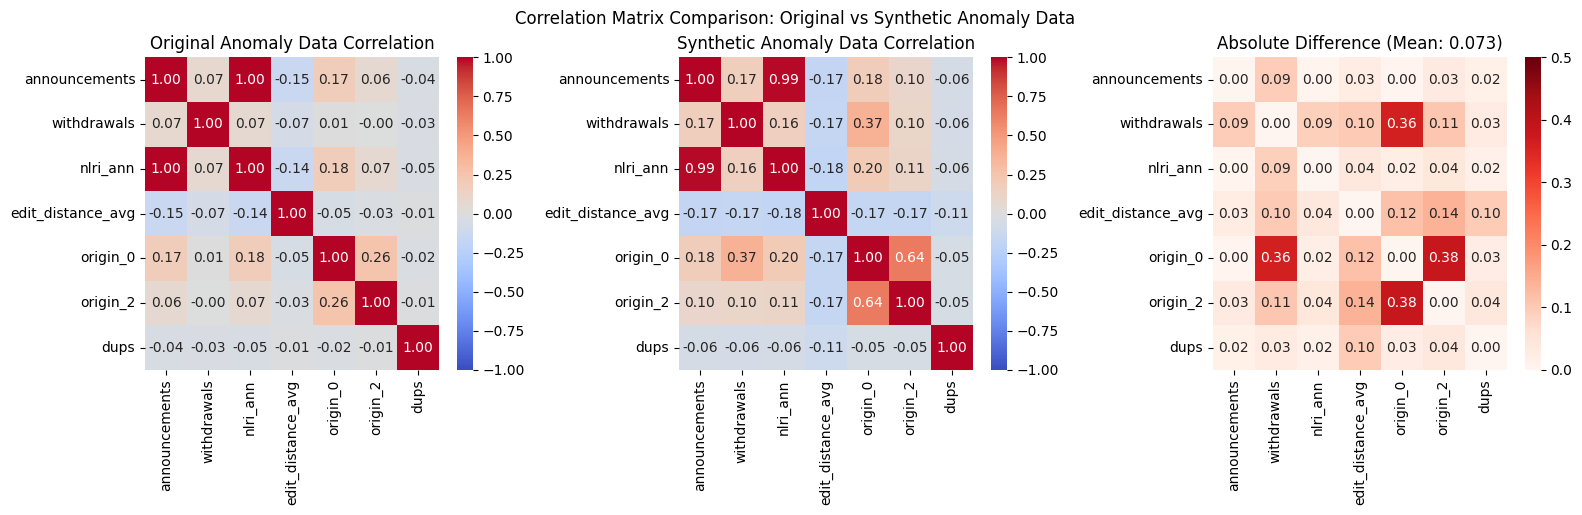

In [179]:
# Plot correlation comparison
fig = plot_correlation_comparison(corr_results)
plt.suptitle('Correlation Matrix Comparison: Original vs Synthetic Anomaly Data', y=1.02)
plt.show()

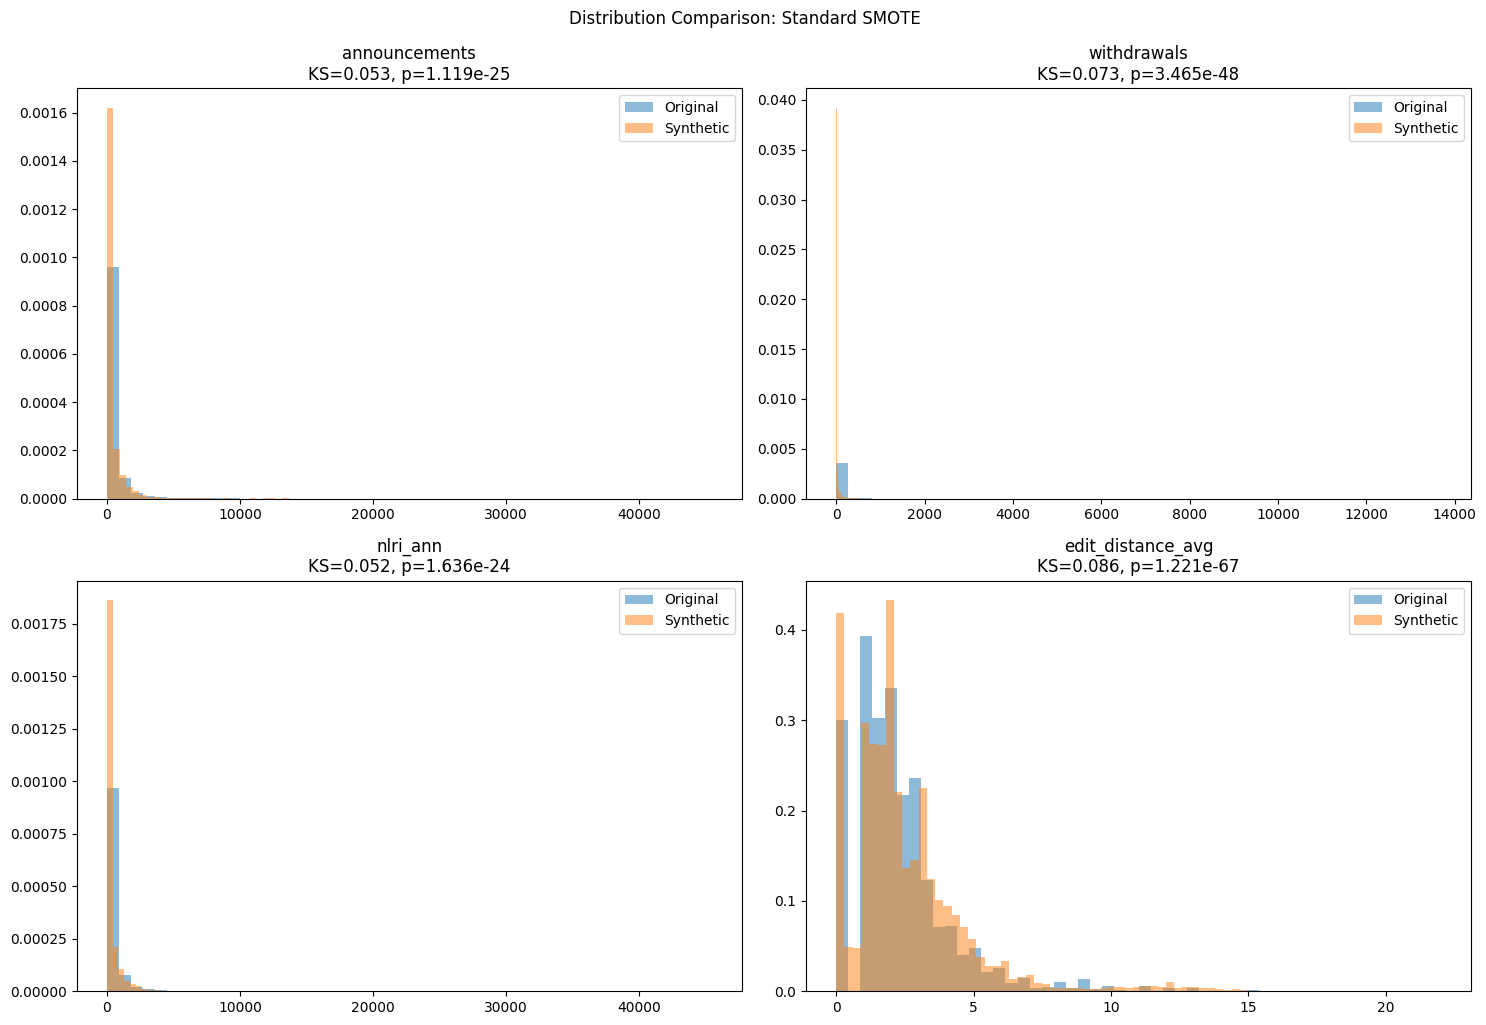

In [180]:
# Plot distribution comparison
fig = plot_distribution_comparison(X_anomaly, synthetic_smote, CORE_VALIDATION_FEATURES)
plt.suptitle('Distribution Comparison: Standard SMOTE', y=1.02)
plt.show()

## 14. Enhanced Statistics Comparison

In [181]:
# Detailed statistics comparison for each method
stats_comparison = {}

for name, synthetic in methods.items():
    stats_df = compare_statistics_enhanced(X_anomaly, synthetic, name)
    stats_comparison[name] = stats_df
    print(stats_df.to_string(index=False))


Enhanced Comparison: Standard SMOTE
                    Feature Orig Mean Synth Mean     Mean Diff % Orig Std Synth Std      Std Diff % KS Stat Quality
              announcements    508.99     456.87           10.2%  1424.58   1222.30           14.2%   0.053    Good
                withdrawals     39.50      19.66           50.2%   190.58     59.08           69.0%   0.073    Good
                   nlri_ann    450.66     388.06           13.9%  1395.85   1122.23           19.6%   0.052    Good
                       dups      0.49       0.34           31.1%     2.09      1.15           45.1%   0.029    Good
                   origin_0     30.48      46.79           53.5%   287.01    276.44            3.7%   0.026    Good
                   origin_2      1.40       1.97           40.1%    35.53     11.21           68.5%   0.029    Good
             origin_changes      0.05       0.02           49.4%     1.12      0.21           81.3%   0.004    Good
                     imp_wd     23.

## 15. Quality Summary Across Methods

In [182]:
# Summary comparison
print("\n" + "="*70)
print("QUALITY SUMMARY ACROSS ALL METHODS")
print("="*70)

summary_data = []
for name, ks_df in ks_results_all.items():
    avg_ks = ks_df['KS Statistic'].mean()
    n_good = (ks_df['Quality'] == 'Good').sum()
    n_fair = (ks_df['Quality'] == 'Fair').sum()
    n_poor = (ks_df['Quality'] == 'Poor').sum()
    
    # Correlation preservation for this method
    corr_result = compare_correlation_matrices(X_anomaly, methods[name])
    
    summary_data.append({
        'Method': name,
        'Avg KS Stat': f'{avg_ks:.4f}',
        'Good Features': n_good,
        'Fair Features': n_fair,
        'Poor Features': n_poor,
        'Corr Diff': f"{corr_result['mean_diff']:.4f}",
        'Validated': 'Yes' if validation_results[name] else 'No'
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


QUALITY SUMMARY ACROSS ALL METHODS
          Method Avg KS Stat  Good Features  Fair Features  Poor Features Corr Diff Validated
  Standard SMOTE      0.0477             26              1              0    0.0734       Yes
Borderline SMOTE      0.1231             11             13              3    0.4032       Yes
          ADASYN      0.0475             26              1              0    0.0715       Yes
   K-Means SMOTE      0.0301             26              1              0    0.0302       Yes
Stratified SMOTE      0.0582             23              4              0    0.0307        No


In [183]:
# Recommend best method
print("\n" + "="*70)
print("RECOMMENDATION")
print("="*70)

# Find method with lowest average KS statistic
best_method = min(ks_results_all.items(), key=lambda x: x[1]['KS Statistic'].mean())
print(f"\nBest method based on KS statistic: {best_method[0]}")
print(f"Average KS statistic: {best_method[1]['KS Statistic'].mean():.4f}")


RECOMMENDATION

Best method based on KS statistic: K-Means SMOTE
Average KS statistic: 0.0301


## 16. Save Synthetic Anomaly Data

In [184]:
def prepare_output(synthetic_df, method_name, include_validation=True):
    """Prepare synthetic data for output with proper labels and metadata."""
    output_df = synthetic_df.copy()

    # 1) Add timestamp column (1‑minute steps from 2024‑01‑01)
    output_df.insert(
        0,
        'timestamp',
        pd.date_range('2024-01-01', periods=len(output_df), freq='1min')
    )

    # 2) Add label column
    output_df['label'] = 'synthetic_anomaly'

    return output_df

# Create output directory
OUTPUT_DIR = '/home/smotaali/BGP_Traffic_Generation/synthetic_anomaly_data/SMOTE_enhanced'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Output directory: {OUTPUT_DIR}")
print("\nSaving synthetic anomaly data...")

Output directory: /home/smotaali/BGP_Traffic_Generation/synthetic_anomaly_data/SMOTE_enhanced

Saving synthetic anomaly data...


In [185]:
# Save all methods
for name, synthetic in methods.items():
    # 1) enrich dataframe with timestamp + label
    method_key = name.lower().replace(' ', '_').replace('-', '_')
    synthetic_out = prepare_output(synthetic, method_key)

    # 2) Create filename from method name
    filename = method_key + '_anomaly.csv'
    filepath = os.path.join(OUTPUT_DIR, filename)

    # 3) Save enriched dataframe
    synthetic_out.to_csv(filepath, index=False)
    print(f"Saved: {filepath} ({len(synthetic_out)} samples)")


Saved: /home/smotaali/BGP_Traffic_Generation/synthetic_anomaly_data/SMOTE_enhanced/standard_smote_anomaly.csv (20000 samples)
Saved: /home/smotaali/BGP_Traffic_Generation/synthetic_anomaly_data/SMOTE_enhanced/borderline_smote_anomaly.csv (20000 samples)
Saved: /home/smotaali/BGP_Traffic_Generation/synthetic_anomaly_data/SMOTE_enhanced/adasyn_anomaly.csv (19983 samples)
Saved: /home/smotaali/BGP_Traffic_Generation/synthetic_anomaly_data/SMOTE_enhanced/k_means_smote_anomaly.csv (19993 samples)
Saved: /home/smotaali/BGP_Traffic_Generation/synthetic_anomaly_data/SMOTE_enhanced/stratified_smote_anomaly.csv (19984 samples)


In [186]:
# Save combined dataset (original + best synthetic)
print("\nCreating combined dataset with original + synthetic data...")

# Use Standard SMOTE as default best method
best_synthetic = synthetic_smote.copy()

# Add labels
df_original_labeled = X_anomaly.copy()
df_original_labeled['data_source'] = 'original'
df_original_labeled['label'] = 'anomaly'

df_synthetic_labeled = best_synthetic.copy()
df_synthetic_labeled['data_source'] = 'synthetic'
df_synthetic_labeled['label'] = 'anomaly'

# Combine
df_combined = pd.concat([df_original_labeled, df_synthetic_labeled], ignore_index=True)

# Save combined
combined_filepath = os.path.join(OUTPUT_DIR, 'combined_anomaly_data.csv')
df_combined.to_csv(combined_filepath, index=False)
print(f"Saved combined data: {combined_filepath}")
print(f"  Original samples: {len(X_anomaly)}")
print(f"  Synthetic samples: {len(best_synthetic)}")
print(f"  Total: {len(df_combined)}")


Creating combined dataset with original + synthetic data...
Saved combined data: /home/smotaali/BGP_Traffic_Generation/synthetic_anomaly_data/SMOTE_enhanced/combined_anomaly_data.csv
  Original samples: 21439
  Synthetic samples: 20000
  Total: 41439


In [187]:
# Final summary
print("\n" + "="*70)
print("SYNTHETIC ANOMALY DATA GENERATION COMPLETE")
print("="*70)

print(f"\nInput Data:")
print(f"  Source: {DATA_PATH}")
print(f"  Confidence labels used: {HIGH_CONFIDENCE_LABELS}")
print(f"  Original high-confidence anomaly samples: {len(X_anomaly)}")

print(f"\nGeneration Settings:")
print(f"  Target synthetic samples: {N_SYNTHETIC}")
print(f"  Log transform: {USE_LOG_TRANSFORM}")
print(f"  BGP constraints: {ENFORCE_BGP_CONSTRAINTS}")

print(f"\nMethods used:")
for name in methods.keys():
    print(f"  - {name}")

print(f"\nOutput files saved to: {OUTPUT_DIR}")
for f in os.listdir(OUTPUT_DIR):
    filepath = os.path.join(OUTPUT_DIR, f)
    size = os.path.getsize(filepath) / 1024  # KB
    print(f"  - {f} ({size:.1f} KB)")


SYNTHETIC ANOMALY DATA GENERATION COMPLETE

Input Data:
  Source: /home/smotaali/BGP_Traffic_Generation/RIPE/RIPE_INCIDENTS/all_incidents_anomalies_reinforced_v2.csv
  Confidence labels used: ['medium_confidence', 'high_confidence', 'very_high_confidence']
  Original high-confidence anomaly samples: 21439

Generation Settings:
  Target synthetic samples: 20000
  Log transform: True
  BGP constraints: True

Methods used:
  - Standard SMOTE
  - Borderline SMOTE
  - ADASYN
  - K-Means SMOTE
  - Stratified SMOTE

Output files saved to: /home/smotaali/BGP_Traffic_Generation/synthetic_anomaly_data/SMOTE_enhanced
  - stratified_smote_anomaly.csv (2603.2 KB)
  - standard_smote_anomaly.csv (2585.9 KB)
  - combined_anomaly_data.csv (4367.5 KB)
  - kmeans_diff (4.0 KB)
  - adasyn_anomaly.csv (2581.6 KB)
  - borderline_smote_anomaly.csv (2593.1 KB)
  - k_means_smote_anomaly.csv (2574.8 KB)


In [188]:
# Display sample of final synthetic data
print("\nSample of generated synthetic anomaly data (Standard SMOTE):")
synthetic_smote.head(10)


Sample of generated synthetic anomaly data (Standard SMOTE):


,announcements,withdrawals,nlri_ann,dups,origin_0,origin_2,origin_changes,imp_wd,imp_wd_spath,imp_wd_dpath,...,edit_distance_dict_4,edit_distance_dict_5,edit_distance_dict_6,edit_distance_unique_dict_0,edit_distance_unique_dict_1,number_rare_ases,nadas,flaps,edit_distance_avg,rare_ases_avg
0,145,2,40,1,0,0,0,60,1,59,...,0,0,0,0,21,25,1,0,1.972612,0.031695
1,651,56,640,0,602,49,2,1,0,1,...,1,0,0,0,1,137,0,0,1.278389,0.037080
2,1577,3,1493,0,0,0,0,9,1,8,...,0,0,0,0,5,201,1,0,1.055923,0.028392
3,56,6,24,0,0,0,0,21,11,9,...,0,0,0,0,2,21,0,0,4.186349,0.066592
4,778,22,562,0,0,0,0,2,0,2,...,0,0,0,0,1,113,1,0,2.122021,0.032635
5,1394,590,746,0,0,0,0,0,0,0,...,0,0,0,0,0,7,561,0,0.751819,0.002582
6,82,1,43,4,0,0,0,24,2,22,...,0,0,0,0,17,23,0,0,1.131281,0.055030
7,584,47,429,0,0,0,0,1,0,1,...,1,0,0,0,0,88,7,0,4.438554,0.034042
8,79,0,53,0,0,0,0,16,15,1,...,0,0,0,0,1,28,0,0,0.167963,0.112325
9,886,16,621,0,0,0,0,68,4,64,...,0,0,0,0,2,130,0,0,2.839851,0.028143
